#           Food Demand Forecasting with Fb prophet: Analytics Vidhya
#### Author: Biman Rakshit  

Demand forecasting is a key component to every growing online business.A food delivery service has to deal with a lot of perishable raw materials which makes it all the more important for such a company to accurately forecast daily and weekly demand.

Our client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants us to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

1.Historical data of demand for a product-center combination (Weeks: 1 to 145)

2.Product(Meal) features such as category, sub-category, current price and discount

3.Information for fulfillment center like center area, city information etc.

## Obatining the Data: 

In [1]:
import pandas as pd #data processing, csv file I/O eg.(pd.read_csv)
import numpy as np #Linear algebra
#import the datasets
Train_df = pd.read_csv("C:/Users/user/Desktop/Data Science Projects/Analytics Vidhya-Food demand Problem/Data/Train.csv")
Center_df = pd.read_csv("C:/Users/user/Desktop/Data Science Projects/Analytics Vidhya-Food demand Problem/Data/fulfilment_center_info.csv")
Meal_df = pd.read_csv("C:/Users/user/Desktop/Data Science Projects/Analytics Vidhya-Food demand Problem/Data/meal_info.csv")

In [2]:
#quick look at the datasets
Train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [3]:
Center_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [4]:
Meal_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


Now I merged them to a dataset where we can access all of the informations provided in this three different datasets. We can perform this megre using several join in the pyhton,or SQl.I proceded the eaisest way as I used 'VLOOKUP' in the Microsoft Excel to to combine them and stored the dataset names as 'main_train.csv'

let's Have look at that dataset.

In [5]:
#stored the merged dataset named df
df = pd.read_csv("C:/Users/user/Desktop/Data Science Projects/Analytics Vidhya-Food demand Problem/Data/main_train.csv")
#to get a preview of first 10 rows
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


## Missing values: 

The task is to predict the num of orders for ecah center meal combination for 10 weeks. Now to find out the missing values we can check by groupby the meal and center IDs on week.

So let's proceed.

In [6]:
#check missing values
df_1 = df.groupby(['center_id', 'meal_id'])['week'].count()
df_1.head(20)

center_id  meal_id
10         1062       145
           1109       145
           1198       145
           1207       144
           1216       143
           1230       145
           1247       122
           1248       145
           1311       145
           1438       143
           1445       145
           1525       137
           1543       145
           1558       144
           1571        82
           1727       145
           1754       145
           1770       144
           1778       145
           1803       145
Name: week, dtype: int64

As we can see not all meal ID is comprises of 145 weeks of data. Hence we have left with two option to deal with the missing data.and they are as follows:

                        1>ignore the missing values 
                        2>replace them with 0,NA,mean,bfill,ffill etc.
                        
Prophet has no problem with missing data. If you set their values to NA in the history but leave the dates in future, then Prophet will give you a prediction for their values. So we wil leave them as is because in the test data those values are missing too.


But we have drop the combinations which are having the data for less than 2 weeks as Prophet cannot be used when number of rows (which are not null) in the data you're passing is less than 2. So  the model cannot do the prediction in that case and we will get a error.

Now removing them won't create any problem if the test dataframe does not have those values, otherwise we have to treat them differently.In our case the test dataframe dont have those values.

In [7]:
#to identify the the combinations having less then two week of data
df['center_meal'] = df['center_id'].astype(str)+"_"+df['meal_id'].astype(str)
df['center_meal'].value_counts().tail()

97_2956     3
41_1248     3
145_2104    1
101_1571    1
145_1571    1
Name: center_meal, dtype: int64

In [8]:
#removing them from the existing dataframe and creating a new dataframe
cnt = df.groupby('center_meal')['week'].count().reset_index()
cnt = cnt[cnt['week'] >= 2]
#creating a list with the unique datasets
cnt_list = list(cnt['center_meal'].unique())
df_new = df[df['center_meal'].isin (cnt_list)]
df_new['center_meal'].value_counts().tail()

97_2956     3
92_2577     3
24_1248     3
139_2577    3
41_1248     3
Name: center_meal, dtype: int64

In [9]:
#let's look at the new dataframe
df_new.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,center_meal
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,55_1885
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,55_1993
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,55_2539
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,55_2139
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,55_2631


## Exploratory Data Analysis:

The task is to predict the forecasted 'num_orders' for each 'center_id', 'meal_id' combination. Hence as each combination is a seperate dataset with 145 weeks of data for which we have to forecast. So let's split one datfarme to observe the EDA.

In [10]:
df_01 = df[df['center_id']==55]
df_01 = df_01[df_01['meal_id']==1885]
df_01.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,center_meal
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,55_1885
2922,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai,55_1885
5818,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai,55_1885
8717,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai,55_1885
11606,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai,55_1885


Now as we got outr dataset let's go for Exploratory Data Analysis. we can observe relationships between several attributes.eg. week~num_orders to check if there is any seasonality over weeks for the num_orders. So let's observe a few if we can have some import point to notice.

In [17]:
import matplotlib.pyplot as plt #Matlab style plot
%matplotlib inline
import seaborn as sns #Statistical Graphs
#ignoring useless warnings not to get ab ugly ouput is a normal practice
import warnings
warnings.filterwarnings("ignore")

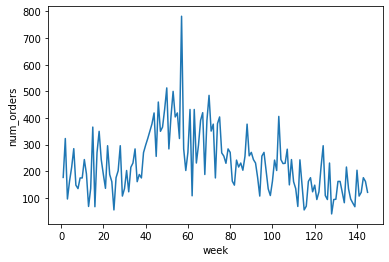

In [12]:
#to check any seasonality of num_orders over weeks
sns.lineplot(x='week',y='num_orders',data=df_01)

Any predictable fluctuation or pattern that recurs or repeats over a one-year period is said to be seasonal.The lineplot cleary shows that the trend does not follow any pattern of seasonality over the weeks.

Next thing we can observe that between week 40-60 there is a spike in the num_orders. Now to identify that we should look at other variable in dataframe and as all the other informations are almost same as we are obseerving for a particular combination other than 'emailer_for_promotion' and 'homepage_featured' So let's observe how they have impacted the num_orders. 

In [13]:
#let's look at the num_orders where emailer for promotion was made for the meal
a = df_01[df_01['emailer_for_promotion']==1]
a[['num_orders','week']]

,num_orders,week
151796,406,52
154989,500,53


In [14]:
#let's look at the num_orders where the meal was featured in homepage 
b = df_01[df_01['homepage_featured']==1]
b[['num_orders','week']]

,num_orders,week
142451,433,49
145580,513,50
148697,284,51
151796,406,52
154989,500,53
158185,404,54
161313,419,55
164492,323,56
167576,782,57


In [15]:
#mean of the num_order variable
df_01['num_orders'].mean()

230.32413793103447

So we can clearly see that whenever the meal id was promoted via homepage notification or by email the number of orders went much higher.

Hence this numbers pretty much explains the spike in the lineplot so we are going to use these two variables as additional factor to the model such that the outliers will be becom easier to fit with the trend changes in history.

## Modelling the Fbprophet: 

The FbProphet procedure is an additive regression model with four main components: A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data. 

The input to Prophet is always a dataframe with two columns: ds and y as 'YYYY-MM-DD HH:MM:SS' for a timestamp and the y column must be numeric.Hence we will assign random dates with a frequency of week as 'W' and will name the column 'ds' and rename the 'num_orders' as 'y' to get the desired format.

First we have to install the fbprophet module.


In [18]:
#installing fbprophet
#as we are using anaconda for this jupyter notebook.
#we just have to make sure that the anaconda environment for commandpromt has 'pystan' package.
!pip install fbprophet
import fbprophet
from fbprophet import Prophet

You should consider upgrading via the 'c:\users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


Now let's apply the fbprophet module to each of the dataframes with unique 'center_id' and 'meal_id' comnination.

The first thing we need to do is introduce a date column in the dataset as fbprophet works only if the datetime variable is present in the data.

In [19]:
#creating a empty dataframe to include the column ds
empty_df = pd.DataFrame(pd.date_range(start='2020-05-17',end='2023-02-19',freq='W',name='ds'))
empty_df['week'] = [i for i in range(1,146)]

In [20]:
#Creating another empty dataframe to store the results
final_df = pd.DataFrame()
center_meal_list = list(df_new['center_meal'].unique())

In [21]:
# now the fbprophet 
for i in center_meal_list:
    df_cent_meal = df_new[df_new['center_meal']== i].reset_index()
    #performing left join to include the dates
    full_data = pd.merge(empty_df,df_cent_meal,on=['week'],how='inner')
    full_data.rename(columns = {'num_orders':'y'}, inplace = True)
    full_data_1 = full_data[['ds','y']]
    #fits_method
    #any settings to the forecasting procedure are passed into the constructor
    #prophet properties are set as per the week data and trend
    m = Prophet(seasonality_mode='multiplicative',weekly_seasonality=True, daily_seasonality=False)
    m.fit(full_data_1)
    #for a number of prediction of 10 weeks with a week frequncy
    future = m.make_future_dataframe(periods=10,freq='W')
    forecast = m.predict(future)
    #adjusting the columns we need
    test_pred = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)
    test_pred['center_meal'] = i
    final_df = pd.concat([final_df, test_pred], ignore_index = True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabli

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater tha

In [22]:
#just a look at the final dataframe
final_df.head(11)

,ds,yhat,yhat_lower,yhat_upper,center_meal
0,2023-02-26,94.865601,-7.363427,196.970349,55_1885
1,2023-03-05,99.663818,-4.226363,200.255813,55_1885
2,2023-03-12,101.542262,-8.416784,211.873367,55_1885
3,2023-03-19,95.626004,-8.450948,196.939583,55_1885
4,2023-03-26,84.471727,-14.030386,189.162124,55_1885
5,2023-04-02,76.668708,-27.985290,175.006214,55_1885
6,2023-04-09,78.394386,-23.437365,181.297378,55_1885
7,2023-04-16,87.048406,-13.236937,188.532066,55_1885
8,2023-04-23,93.856322,-8.258719,188.057677,55_1885
9,2023-04-30,92.440394,-9.708959,196.702564,55_1885


Now as we got the forecasted values for the 10 weeks in future for each center-combination. let's load the test dataset and assign the values of the data respectively.

In [29]:
#importing the test data and creating the center_meal column
df_test = pd.read_csv("C:/Users/user/Desktop/Data Science Projects/Analytics Vidhya-Food demand Problem/Data/test_QoiMO9B.csv")
df_test['center_meal'] = df_test['center_id'].astype(str)+"_"+df_test['meal_id'].astype(str)
df_test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,center_meal
0,1028232,146,55,1885,158.11,159.11,0,0,55_1885
1,1127204,146,55,1993,160.11,159.11,0,0,55_1993
2,1212707,146,55,2539,157.14,159.14,0,0,55_2539
3,1082698,146,55,2631,162.02,162.02,0,0,55_2631
4,1400926,146,55,1248,163.93,163.93,0,0,55_1248


Now as we have loaded the test data let's introduce the 'ds' term as we did in the train data, by creating an empty dataset with week and time and performing a left join to the test data.

In [24]:
#created a datfarme to include the date stamps of future prediction
empty_df_test = pd.DataFrame(pd.date_range(start='2023-02-26',end='2023-04-30',freq='W',name='ds'))
empty_df_test['week'] = [i for i in range(146,156)]
empty_df_test.head(10)

,ds,week
0,2023-02-26,146
1,2023-03-05,147
2,2023-03-12,148
3,2023-03-19,149
4,2023-03-26,150
5,2023-04-02,151
6,2023-04-09,152
7,2023-04-16,153
8,2023-04-23,154
9,2023-04-30,155


In [25]:
#to get a desirebale format before the merging
submit_df = pd.merge(empty_df_test,df_test,on=['week'],how='left')
submit_df.head(11)

,ds,week,id,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,center_meal
0,2023-02-26,146,1028232,55,1885,158.11,159.11,0,0,55_1885
1,2023-02-26,146,1127204,55,1993,160.11,159.11,0,0,55_1993
2,2023-02-26,146,1212707,55,2539,157.14,159.14,0,0,55_2539
3,2023-02-26,146,1082698,55,2631,162.02,162.02,0,0,55_2631
4,2023-02-26,146,1400926,55,1248,163.93,163.93,0,0,55_1248
5,2023-02-26,146,1284113,55,1778,190.15,190.15,0,0,55_1778
6,2023-02-26,146,1197966,55,1062,191.09,192.09,0,0,55_1062
7,2023-02-26,146,1132739,55,2707,242.56,240.56,0,0,55_2707
8,2023-02-26,146,1057981,55,1207,360.90,360.90,0,0,55_1207
9,2023-02-26,146,1095932,55,1230,383.18,384.18,0,0,55_1230


Now it's time to store the forecasted values to each individual id to get the format for submission.

In [26]:
#merging the final_df with the test data
submit_df_1 = pd.merge(submit_df,final_df,on = ['center_meal','ds'],how='left')
submit_df_1.head(10)

,ds,week,id,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,center_meal,yhat,yhat_lower,yhat_upper
0,2023-02-26,146,1028232,55,1885,158.11,159.11,0,0,55_1885,94.865601,-7.363427,196.970349
1,2023-02-26,146,1127204,55,1993,160.11,159.11,0,0,55_1993,103.825899,-13.881916,208.851938
2,2023-02-26,146,1212707,55,2539,157.14,159.14,0,0,55_2539,156.832089,57.442468,251.830551
3,2023-02-26,146,1082698,55,2631,162.02,162.02,0,0,55_2631,85.630575,46.464069,126.377231
4,2023-02-26,146,1400926,55,1248,163.93,163.93,0,0,55_1248,36.249196,0.385497,68.506341
5,2023-02-26,146,1284113,55,1778,190.15,190.15,0,0,55_1778,210.660458,77.367026,347.150637
6,2023-02-26,146,1197966,55,1062,191.09,192.09,0,0,55_1062,225.746899,99.837881,336.744445
7,2023-02-26,146,1132739,55,2707,242.56,240.56,0,0,55_2707,192.376790,43.711826,335.306908
8,2023-02-26,146,1057981,55,1207,360.90,360.90,0,0,55_1207,66.999760,-72.962269,210.686571
9,2023-02-26,146,1095932,55,1230,383.18,384.18,0,0,55_1230,77.830401,-69.757496,230.904552


Now we are going to implement the effect of 'emailer_for_promotion' and 'homepage_featured'.As our EDA showed that when this two factor have a value the 'num_orders' jumps to a very high value. So let's identify those values and replace the value of 'yhat' with 'yhat_upper' for those cases.

In [27]:
#implementing the the additional factor effect
submit_df_1['num_orders'] = submit_df_1.apply(lambda x: x['yhat_upper'] if x['emailer_for_promotion']==1 or x['homepage_featured']==1 else x['yhat'],axis=1)
submit_df_1.head()

,ds,week,id,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,center_meal,yhat,yhat_lower,yhat_upper,num_orders
0,2023-02-26,146,1028232,55,1885,158.11,159.11,0,0,55_1885,94.865601,-7.363427,196.970349,94.865601
1,2023-02-26,146,1127204,55,1993,160.11,159.11,0,0,55_1993,103.825899,-13.881916,208.851938,103.825899
2,2023-02-26,146,1212707,55,2539,157.14,159.14,0,0,55_2539,156.832089,57.442468,251.830551,156.832089
3,2023-02-26,146,1082698,55,2631,162.02,162.02,0,0,55_2631,85.630575,46.464069,126.377231,85.630575
4,2023-02-26,146,1400926,55,1248,163.93,163.93,0,0,55_1248,36.249196,0.385497,68.506341,36.249196


In [28]:
#to submit the file as the sample submission format
submission_df = submit_df_1[['id','num_orders']]
submission_df.head()

,id,num_orders
0,1028232,94.865601
1,1127204,103.825899
2,1212707,156.832089
3,1082698,85.630575
4,1400926,36.249196


In [53]:
# saving final submission to csv
final_sub_file = submit_df_1.copy()
final_sub_file.to_csv("C:/Users/user/Desktop/Data Science Projects/Analytics Vidhya-Food demand Problem/Data/final_submission_v01_fbprophet.csv", index = False)
#before submitting the result

The evaluation metric for this competition is 100*RMSLE where RMSLE is Root of Mean Squared Logarithmic Error across all entries in the test set.Test data is further randomly divided into Public (30%) and Private (70%) data.Your initial responses will be checked and scored on the Public data and the score I achieved is 60.6078205388272.